# Notes

### Option 1: DICOM files
#### 2021
* Version 5: 
- adding roc_auc to metrics
- import gc for performance
- 

* 30.03.2021: no GPU Supoort for fastaiV2, training super long
* 02.04.2021: move to colab

#### 2020
* 29.06.2020: NEW Notebook in GDrive w Colab
* 30.06.2020
    - switcht to Kaggle since dataset to big for gDrive
    - lr_find 2.5hours -> image Resize 128 -> 64 / bs 32 -> 16, sample 100 -> 50

DICOM Files Start
https://www.kaggle.com/avirdee/fastai2-dicom-starter/notebook

### Option 2: with JPEG (see colab)


### Option 3: different tfrecord dataset (in various size available)
https://www.kaggle.com/cdeotte/melanoma-256x256



## 1. Setup

In [1]:
!pip install pydicom kornia opencv-python scikit-image nbdev
!pip install fastcore
#Install/upgrade fastai package
!pip install --upgrade fastai

      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
!pip install -Uqq fastbook

     |████████████████████████████████| 727kB 4.2MB/s 
     |████████████████████████████████| 1.2MB 7.5MB/s 


### performance hacks

In [ ]:
# get more RAM
# i = []
# while(True):
#     i.append('a')

# not working. no pop_up windows where you can click "get more RAM" :()

In [ ]:
# add this to console so colab does not disconnect since idle

In [ ]:
# function KeepClicking(){
#    console.log("Clicking");
#    document.querySelector("colab-toolbar-button#connect").click()
# }setInterval(KeepClicking,60000)

### load dependencies etc.

In [4]:
# connect to GoogleDrive
import fastbook
fastbook.setup_book()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g5rCcNPrhtNMuxYBKolv5Kysc8oyT7L3CWGBBxrI_sCwYUgIO_VDoQ
Mounted at /content/gdrive


In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# load dependancies
import torch, torchvision
import fastcore
import fastai
from fastai.basics import *
from fastai.data.all import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *

import pydicom

import seaborn as sns

import numpy as np
import pandas as pd
import os


print(f'Notebook last run on {datetime.fromtimestamp(time.time()).strftime("%Y-%m-%d, %H:%M:%S UTC")}')
print('Using fastai version ',fastai.__version__)
print(f'fastcore version {fastcore.__version__} installed.')
print('And torch version ',torch.__version__)
print("PyDicom", pydicom.__version__)
# print("GPU available", torch.cuda.is_available())
# print(" GPU", torch.cuda.get_device_name(0))
# print("GPU ", torch.backends.cudnn.enabled)


# ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

Notebook last run on 2021-04-04, 04:43:46 UTC
Using fastai version  2.3.0
fastcore version 1.3.19 installed.
And torch version  1.7.1
PyDicom 2.1.2


In [ ]:
## for reproducability set seed
def seed_everything(seed=0):
  random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
seed_everything()

In [ ]:
# Setup Kaggle

# # connect kaggle
# from google.colab import files
# files.upload()

# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json


## 2. Data

* using DICOM files from train folder

In [ ]:
path = Path('/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma')
dicom_path = os.path.join(path, 'DICOM')
# dicom_path = Path('/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/DICOM')
print(path)
print(dicom_path)
# files = os.listdir(path)

/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma
/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/DICOM


### 2.1 Get data 
run only once

In [ ]:
### Get partial Data (since Dataset w. 100+GB to big)

# !kaggle competitions list -s siim

In [ ]:
# !pip install wget

In [ ]:
## workaround to download only part of dataset
# import wget
# import zipfile as zf

# url = "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/20270/1222630/compressed/train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1617571181&Signature=SsQA86XYEjTMGnUs27nnNTAcl9n%2BrY%2FJH1Csj08he1XQj%2F4iq6rR2xHuzgp0cF%2FHxqHUpjab2iNtcaydVBmGTXq7rneKFfEoTKkhORO8nJkPGbBhQCz2IOwFlpibpYh1EZlAdhmsvnyUccHp6tqq%2Bph59q9sSafm%2B8gh7jRIBH6Y5xOrpHxgy81NVs9h%2FUHllCDBf%2F2NZxIaTiynleYG9zzV30HoQ3pM6SHeLYB1VZnkR9V%2BUTFLcze%2FNFjxxrWW92%2B49edLE1SkKzIMYMLHbbf7AoMMK3UAvkwxmktJmSJujFzBxugiVzMry2A5chagUsXSVw2Fp9eHH880FbR2Aw%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.zip"
# path_dicom = path/'DICOM'
# wget.download(url , '/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/DICOM/train.zip')


In [ ]:
# unzip
# dicom_images = Path(path/'dicom_train.zip')

# # # not enough space on gdrive for extraction / 04.01.2021
# with zipfile.ZipFile(dicom_images, 'r') as zip_ref:
#   zip_ref.extractall(dicom_path)

In [ ]:
# Download only DICOM relevant csv files
# !kaggle competitions download -c "siim-isic-melanoma-classification" -f test.csv
# !kaggle competitions download -c "siim-isic-melanoma-classification" -p 'sample_data/melanoma-data' -f test.csv

### 2.2. Check images and data

In [ ]:
dicom_img = os.listdir(dicom_path)
len(dicom_img)

22202

In [ ]:
# check if only dicom files in folder
assert len(glob.glob(os.path.join(dicom_path, '*.dcm'))) == len(os.listdir(dicom_path))

In [ ]:
# only 1/3 of DICOM dataset since limited space on Colab

train = dicom_path
train_files = get_dicom_files(train)
train_files

(#22202) [Path('/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/DICOM/ISIC_4734627.dcm'),Path('/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/DICOM/ISIC_4734111.dcm'),Path('/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/DICOM/ISIC_4735106.dcm'),Path('/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/DICOM/ISIC_4734950.dcm'),Path('/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/DICOM/ISIC_4735120.dcm'),Path('/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/DICOM/ISIC_4735699.dcm'),Path('/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/DICOM/ISIC_4735959.dcm'),Path('/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/DICOM/ISIC_4735706.dcm'),Path('/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/DICOM/ISIC_4737109.dcm'),Path('/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/DICOM/ISIC_4736149.dcm')...]

In [ ]:
# Check img 
patient1 = (train_files[7])
dimg = patient1.dcmread()
# dimg

In [ ]:
# create function to display dicom image and specific tags of DICOM Header
def show_one_patient(file):
    pat = file.dcmread()
    print(f'patient Name {pat.PatientName}')
    print(f'patient ID {pat.PatientID}')
    print(f'patient Age {pat.PatientAge}')
    print(f'patient Sex {pat.PatientSex}')

    trans = Transform(Resize(256))
    dicom_create = PILDicom.create(str(file))
    dicom_transform = trans(dicom_create)
    return show_image(dicom_transform)

patient Name "ISIC^4735706"
patient ID "ISIC_4735706"
patient Age 040Y
patient Sex F


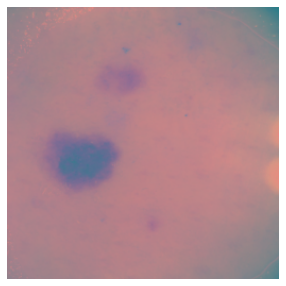

In [ ]:
show_one_patient(train_files[7])

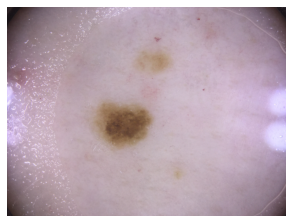

In [ ]:
# transform from colorspace YBR_FULL_422 format to RGB
from pydicom.pixel_data_handlers.util import convert_color_space

arr = dimg.pixel_array
convert = convert_color_space(arr, 'YBR_FULL_422', "RGB")
show_image(convert)

In [ ]:
# view pixel distribution
# px = dimg.pixels.flatten()
# plt.hist(px, color='orange')

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [ ]:
df.shape

(33126, 8)

In [ ]:
####################
# since only partial train set download
# -> create df with only img names in DICOM dir
####################
df_test = df.copy()
df_test = df_test[:-2] #since unzip interupted since lack of space, last files might be corupted

img_list_part = os.listdir(dicom_path)
len(img_list_part)

mapping = {f.split(".")[0]: f for f in img_list_part}

df_test['image_file'] = pd.Series() # create empty new column in df

for img_name, img_file in mapping.items():
  df_test.loc[df_test.image_name == img_name, 'image_file'] = img_file

In [ ]:
df_test.tail()
print(df_test.shape)

(33124, 9)


In [ ]:
df_partial = df_test[df_test['image_file'].notnull()]
df_partial.shape

(22202, 9)

In [ ]:
#########################
## for testing
#########################

# create dataframe from dicom files
# see : https://docs.fast.ai/tutorial.medical_imaging.html

# items = get_dicom_files(dicom_path)
# items
# # dicom_df = pd.DataFrame.from_dicoms(items)
# # dicom_df[:5]
# # dicom_dataframe = pd.DataFrame.from_dicoms(items)
# dicom_dataframe[:5]

### 2.2 EDA


In [ ]:
sns.set(style = 'whitegrid')
sns.set_context('paper')
sns.set_palette('Blues')

In [ ]:
# create Plot to compare features

def plot_comparison(df, feature1, feature2, feature3):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 8))
    
    s1 = sns.countplot(df[feature1], ax=ax1)
    s1.set_title(feature1)
    
    s2 = sns.countplot(df[feature2], ax=ax2)
    s2.set_title(feature2)
    
    s3 = sns.countplot(df[feature3], ax= ax3)
    s3.set_title(feature3)
    
    plt.show()

In [ ]:
# plot_comparison(df, "sex", 'age_approx', 'benign_malignant')
# plot_comparison(df_partial, "sex", 'age_approx', 'benign_malignant')

In [ ]:
def plot_comparison1(df, feature):
    
    fig, (ax) = plt.subplots(1,1, figsize=(20, 8))
    
    s1 = sns.countplot(df[feature], ax = ax)
    s1.set_title(feature)
    
    plt.show()

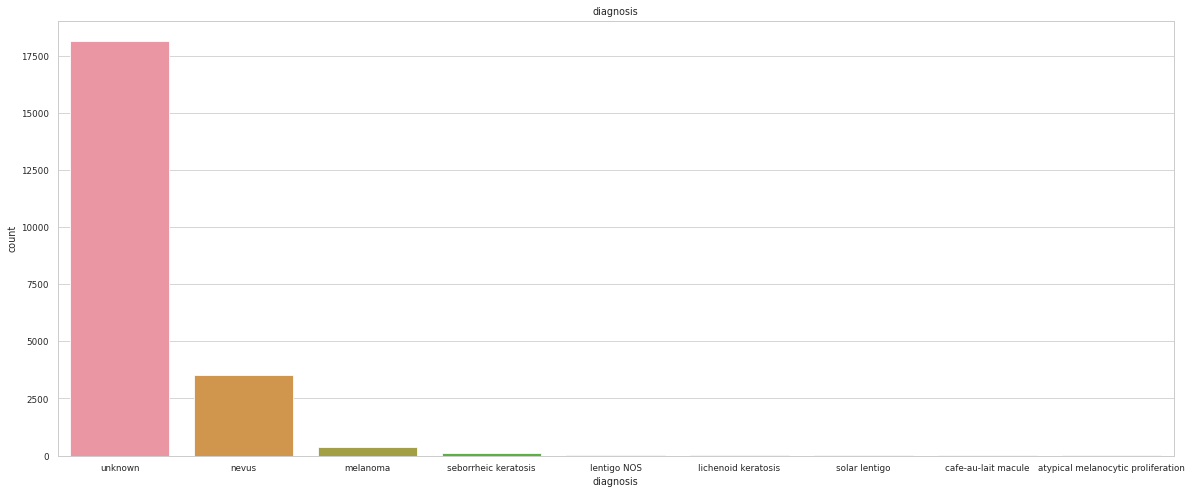

In [ ]:
plot_comparison1(df_partial, 'diagnosis')

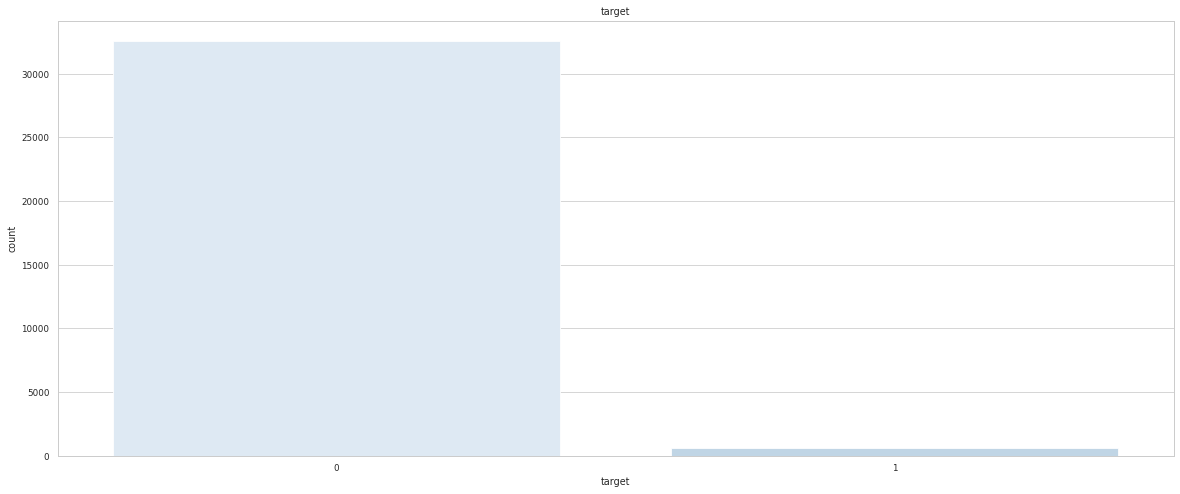

In [ ]:
plot_comparison1(df, 'target')

In [ ]:
## Dataframe for EDA 
eda_df = df_partial[['sex', 'age_approx', 'anatom_site_general_challenge', 'diagnosis', 'target']]
eda_df.head()

,sex,age_approx,anatom_site_general_challenge,diagnosis,target
0,male,45.0,head/neck,unknown,0
1,female,45.0,upper extremity,unknown,0
2,female,50.0,lower extremity,nevus,0
3,female,45.0,head/neck,unknown,0
4,female,55.0,upper extremity,unknown,0


In [ ]:
len(eda_df)

22202

### 2.3 Data Cleaning

In [ ]:
# check for NAN and delete rows
sex_na = eda_df['sex'].isna().sum()
age_na = eda_df['age_approx'].isna().sum()
anatom_na = eda_df['anatom_site_general_challenge'].isna().sum()
print(f'length of eda_df {len(eda_df)}, number of NAN in sex column {sex_na} number of NAN in age column {age_na}, number of NAN in anatom column {anatom_na}')

length of eda_df 22202, number of NAN in sex column 42 number of NAN in age column 45, number of NAN in anatom column 353


In [ ]:
df_drop = eda_df.dropna()
len(df_drop)

21804

In [ ]:
## convert categorical values to labels

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
edaa_df = df_drop.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')
edaa_df.head()

,sex,age_approx,anatom_site_general_challenge,diagnosis,target
0,1,8,0,8,0
1,0,8,5,8,0
2,0,9,1,5,0
3,0,8,0,8,0
4,0,10,5,8,0


In [ ]:
# sns.pairplot(eda_df, hue= 'target', height = 5, aspect=2, palette = 'gist_rainbow_r')

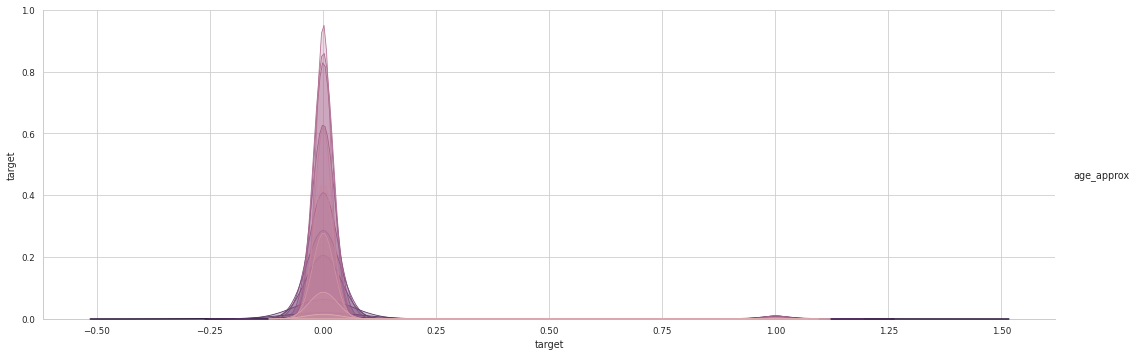

In [ ]:
sns.pairplot(eda_df, hue= 'age_approx', height = 5, aspect=3) 
# since ValueError: `bw_method` should be 'scott', 'silverman', a scalar or a callable
# diag_kws={'bw': '0.05'} -> deleted

## 2.4 Data Preparation for Training

In [ ]:
# since limited space, not able to download and extract all 200GB
# using 22.000 Img
df_complete = df.copy()
df_complete_noNaN = df_complete.dropna()
df = df_partial.copy()
df = df_partial.dropna()
df = df[['image_name', "target"]]

In [ ]:
print(df.shape)
df.head()

(21804, 2)


,image_name,target
0,ISIC_2637011,0
1,ISIC_0015719,0
2,ISIC_0052212,0
3,ISIC_0068279,0
4,ISIC_0074268,0


In [ ]:
# image name

# refactor lambda since not able to pickle when export later
def get_x_func(x):
  return os.path.join(dicom_path, f'{x[0]}.dcm')

# image label
def get_y_func(x):
  return x[1]
# or:
# get_y_func = ColReader('target')

In [ ]:
# since Colorspace not in RGB
class PILDicom2(PILBase):
    _open_args,_tensor_cls,_show_args = {},TensorDicom,TensorDicom._show_args
    @classmethod
    def create(cls, fn:(Path,str,bytes), mode=None)->None:
        "Open a `DICOM file` from path `fn` or bytes `fn` and load it as a `PIL Image`"
        dimg = pydicom.dcmread(fn) 
        # if DICOM file read error in train persists
        # use .dcmread(force=True)
        arr = dimg.pixel_array; 
        convert = convert_color_space(arr,'YBR_FULL_422', 'RGB')
        im = Image.fromarray(convert)
        im.load()
        im = im._new(im.im)
        return cls(im.convert(mode) if mode else im)


In [ ]:
#check which transforms available, choose appropriate
# aug_transforms()

In [ ]:
# 1x ImageBlock and 1 CategoryBlock for Labels
blocks = (ImageBlock(cls=PILDicom2), CategoryBlock)

In [ ]:
melanoma_dblock = DataBlock(blocks = blocks,
                    get_x = get_x_func,
                    get_y = get_y_func,
                    splitter = RandomSplitter(),
                    item_tfms = Resize(64),
                    batch_tfms=[Normalize.from_stats(*imagenet_stats), 
                                *aug_transforms(flip_vert=True, max_lighting=0.1)]
                            # , max_zoom=1.05, max_warp=0. 
                    )

In [ ]:
# dataloader with only 5000 samples for testing so that faster training
# df = df[:200]
dls = melanoma_dblock.dataloaders(df.sample(200), bs=12)
dls

In [ ]:
dls = dls.cuda()
dls

In [ ]:
print(len(dls.train_ds), len(dls.valid_ds))

160 40


In [ ]:
# dls.show_batch(max_n = 10, nrows=3, ncols=4)

In [ ]:
# check batch
# xb, yb = dls.one_batch()
# print(f'Input shape: {xb.shape}, target shape: {yb.shape}.')

## 3. Model

- ResNet34


### 3.1 Create Model

In [ ]:
# FASTAI V1 - not tested for fastai V2
###########################

from sklearn.metrics import roc_auc_score

def get_auc_score(y_true, y_pred, tens = True):
    score = roc_auc_score(y_true, torch.sigmoid(y_pred)[:,1])
    if tens:
        score = tensor(score)
    return score

def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return roc_auc_score(target, input)

# from: https://forums.fast.ai/t/using-auc-as-metric-in-fastai/38917/7
class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_target, last_output, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            self.learn.recorder.add_metrics([metric])
    
#     use in : learn = text_classifier_learner(data_clf, drop_mult=0.3, callback_fns=AUROC)

In [ ]:
# model (small first, n_outputs define with dataloaders.c attribute)
# model = models.xresnet18_deep(n_out = dls.c)
model = models.resnet34

# metrics
# roc = RocAuc()
# acc_02 = partial(accuracy_thresh, thresh=0.2)
# f_score = partial(fbeta, thresh=0.2)

acc = accuracy
metrics = [acc, ]
learn = cnn_learner(dls, 
                     model, 
                     metrics=metrics, 
                     loss_func= LabelSmoothingCrossEntropy(), 
                    ps=0.25,
                    model_dir='/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/models',
                     cbs = ShowGraphCallback(),
                     )


In [ ]:
learn.arch

<function torchvision.models.resnet.resnet34>

In [ ]:
# if GPU enabled:
if torch.cuda.is_available():
    learn.model.cuda()

In [ ]:
# defince Callbacks
earlyStop = EarlyStoppingCallback(monitor='valid_loss', 
                                  min_delta=0.1, 
                                  patience=2)

## default SaveModelCallback:
# SaveModelCallback(monitor='valid_loss', 
#  comp=None, min_delta=0.0, 
#  fname='model', 
#  every_epoch=False, 
#  with_opt=False, 
#  reset_on_fit=True) 
saveModel = SaveModelCallback(every_epoch=True, 
                              fname='melanoma_DICOM_resnet34')

reduceLR = ReduceLROnPlateau(monitor='valid_loss', comp=None, 
                             min_delta=0.0, patience=1, factor=10.0, 
                             min_lr=0, reset_on_fit=True)

callbacks =[earlyStop, reduceLR]

### 3.2. train model

20.04.2021:

In "Manage Session" GPU only UTC-8 16:001.45GB / 21:00 1.69GB Used - 
always with batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)]

1. densenet121with df.sample(100), bs=10, item_tfms=Resize(64)
- lr_find() : 30min / fit_one_cycle: 3min
2. with df (11.000 dicom files), bs=32, item_tfms=Resize(64)
- lr_find() : 4hr / fit_one_cycle: 3.5 hr both estimations not executed - same with bs=8
3. with df (full aka 500 dicom files), bs=32, item_tfms=Resize(64)
- lr_find() : 1.5hr / fit_one_cycle: 1.5 hr both estimations not executed
4. resnet34, df=5000, bs=32, aug_transforms(flip_vert=True, max_lighting=0.1) Items_tfmsResize(64)

### 3.2.1 First run

epoch,train_loss,valid_loss,accuracy,time
0,1.151028,0.760770,0.700000,05:03
1,1.111318,0.713173,0.650000,04:15
2,1.033412,0.765527,0.650000,04:17


Better model found at epoch 0 with valid_loss value: 0.7607696652412415.


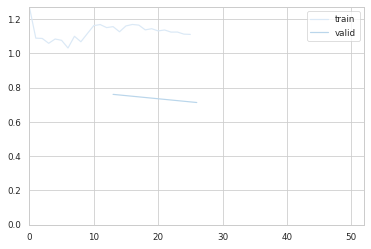

Better model found at epoch 1 with valid_loss value: 0.7131731510162354.
No improvement since epoch 0: early stopping


In [ ]:
# learn.fit_one_cycle(4)

In [ ]:
# learn.save('melanoma-DICOM-resnet34-stage1')

Path('models/melanoma-DICOM-resnet34-stage1.pth')

In [ ]:
# make the rest of the layers trainable
# learn.unfreeze()

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=6.309573450380412e-07)

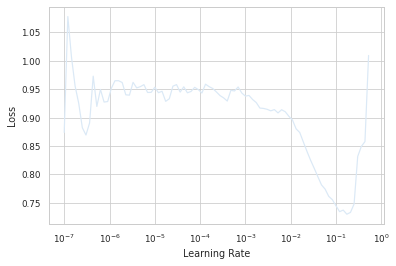

In [ ]:
# learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.012429,4.441028,0.200000,04:20
1,0.943667,0.822441,0.750000,04:17


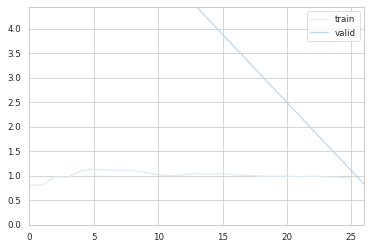

In [ ]:
# learn.fit_one_cycle(2)

In [ ]:
# learn.save('melanoma-DICOM-resnet34-stage1')

Path('models/melanoma-DICOM-resnet34-stage1.pth')

epoch,train_loss,valid_loss,accuracy,time
0,0.669743,0.426050,0.950000,05:01
1,0.643472,0.326132,0.950000,04:22
2,0.560494,0.548953,0.825000,04:26
3,0.514446,0.430304,0.925000,04:24
4,0.481781,0.326165,0.950000,04:23


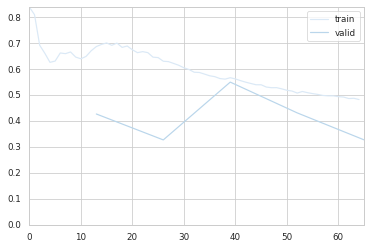

In [ ]:
# learn.fit_one_cycle(5)

### 3.2.2 Second Train Phase

In [ ]:
learn.load('/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/models/melanoma-DICOM-resnet34-stage2')

In [ ]:
## add more images with bigger img size to dls

melanoma_dblock2 = DataBlock(blocks = blocks,
                    get_x = get_x_func,
                    get_y = get_y_func,
                    splitter = RandomSplitter(),
                    item_tfms = Resize(224),
                    batch_tfms=[Normalize.from_stats(*imagenet_stats), 
                                *aug_transforms(flip_vert=True, max_lighting=0.1)]
                            # , max_zoom=1.05, max_warp=0. 
                    )

dls2 = melanoma_dblock2.dataloaders(df.sample(1000), bs= 32)
dls2 = dls2.cuda()
learn.dls = dls2

In [ ]:
print(len(learn.dls.train_ds))
dls.train_ds[0][0].shape

800


(4000, 6000)

In [ ]:
learn.freeze()

In [ ]:
# learn.lr_find()

In [ ]:
learn.fit_one_cycle(n_epoch=5, 
                    cbs=[SaveModelCallback(every_epoch=True, 
                                          fname='melanoma_DICOM_resnet34_stage2'),
                         EarlyStoppingCallback(monitor='valid_loss', 
                                  min_delta=0.1, 
                                  patience=2)]
                    )

epoch,train_loss,valid_loss,accuracy,time
0,0.334416,0.265829,0.985000,23:29
1,0.322581,0.273838,0.985000,23:15
2,0.312991,0.264308,0.985000,23:03


No improvement since epoch 0: early stopping


In [ ]:
learn.save('melanoma_DICOM_resnet_stage3_best')

Path('/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/models/melanoma_DICOM_resnet_stage3_best.pth')

In [ ]:
learn.unfreeze()

In [ ]:
# learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.308145,1.111048,0.985000,23:19
1,0.303359,0.433987,0.985000,23:18
2,0.295791,0.249486,0.985000,22:58


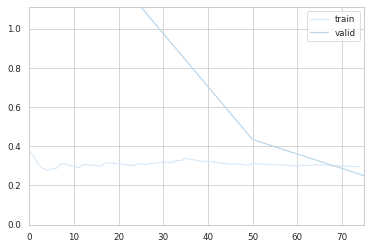

In [ ]:
learn.fit_one_cycle(n_epoch=3,
                    cbs=[SaveModelCallback(every_epoch=True, 
                                          fname='melanoma_DICOM_resnet34_stage4'),
                         EarlyStoppingCallback(monitor='valid_loss', 
                                  min_delta=0.1, 
                                  patience=2)]
                    )

In [ ]:
learn.save('melanoma_DICOM_resnet_stage4_best')

Path('/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/models/melanoma_DICOM_resnet_stage4_best.pth')

In [ ]:
learn.export('/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/models/melanoma_DICOM_resnet34_stage4_best')

AttributeError: ignored

### 3.3 Fine Tuning

In [ ]:
# learn.load('')

In [ ]:
# clean cache and free up GPU
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
dls3 = melanoma_dblock.datasets(df.sample(500), bs=64)
dls3 = dls3.cuda()

learn.dls = dls3

In [ ]:
learn.freeze()

In [ ]:
# learn.lr_find()

In [ ]:
learn.fit_one_cycle(n_epoch=2, 
                    cbs=[SaveModelCallback(every_epoch=True, 
                                          fname='melanoma_DICOM_resnet34_stage5'),
                         EarlyStoppingCallback(monitor='valid_loss', 
                                  min_delta=0.1, 
                                  patience=2)]
                    )

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(n_epoch=4, 
                    cbs=[SaveModelCallback(every_epoch=True, 
                                          fname='melanoma_DICOM_resnet34_stage5'),
                         EarlyStoppingCallback(monitor='valid_loss', 
                                  min_delta=0.1, 
                                  patience=1)]
                    )

In [ ]:
learn.fine_tune(2)

In [ ]:
learn.save('melanoma-DICOM-resnet34-final')

In [ ]:
learn.export(fname='/content/gdrive/MyDrive/Colab Notebooks/kaggle/melanoma/models/Melanoma_DICOM_resnet_final')

## 4. Results

In [ ]:
# test = os.listdir(dicom_path)[10]
# test

test = train_files[10]
learn.predict(test)

In [ ]:
learn.show_results(max_n=6)

In [ ]:
interp = Interpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(12)

In [ ]:
# Confusion Matrix

int_confusion = ClassificationInterpretation.from_learner(learn)

losses, idxs = int_confusion.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
int_confusion.plot_confusion_matrix(figsize=(8,8))

In [ ]:
# Sensitivity and Specificity

upp, low = int_confusion.confusion_matrix()
tn, fp = upp[0], upp[1]
fn, tp = low[0], low[1]
print(tn, fp, fn, tp)

sensitivity = tp/(tp + fn)
print(f'Sensitivity is : {sensitivity}')

specificity = tn /(tn + fp)
print(f'Sepcificity is : {specificity}')

## 4.2 test_set results



In [ ]:
# get the test files

test_path = path/'test'
test_img = get_dicom_files(test_path)

# for testing purpose only firs 100 instances

test_set = test_img[:100]

In [ ]:
## 4.3 create submission file

sample_df = pd.read_csv('sample_submission.csv')

# delete entries in target col since place for predictions
del sample_df['target']

# get predictions for sample_df

sample_list = []

for i in test_set:
    pred = learn.predict(i)
    pred_class = pred[2][1] # need convert to float() ?
    sample_list.append(pred_class)
    


In [ ]:
results_df = pd.DataFrame({'image_name': sample_df['image_name'], 'target': sample_list })

results_df.head()

In [ ]:
results_df.to_csv('submission.csv', index= False)